# Projet de Prédiction des prix d'une maison

## Les importations

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

### Étape 1 : Chargement du dataset depuis le fichier CSV

In [3]:
# Étape 1 : Chargement du dataset depuis le fichier CSV
data = pd.read_csv('HousingData.xls')

### Étape 2 : Exploration initiale des données

In [4]:
# Étape 2 : Exploration initiale des données
print("Aperçu des premières lignes :")
print(data.head())
print("\nInformations sur le dataset :")
print(data.info())
print("\nStatistiques descriptives :")
print(data.describe())
print("\nValeurs manquantes :")
print(data.isnull().sum())

Aperçu des premières lignes :
      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622    3  222     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90    NaN  36.2  

Informations sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS    

### Étape 3 : Vérification de l'asymétrie initiale

In [5]:
# Étape 3 : Vérification de l'asymétrie initiale
print("\nAsymétrie initiale des variables :")
print(data[['MEDV', 'CRIM']].skew())


Asymétrie initiale des variables :
MEDV    1.108098
CRIM    5.212843
dtype: float64


### Gestion des valeurs manquantes

In [6]:
# Gestion des valeurs manquantes avec imputation par la médiane
imputer = SimpleImputer(strategy='median')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

### Vérification de l'asymétrie initiale

In [7]:
#Vérification de l'asymétrie initiale
print("\nAsymétrie initiale des variables :")
print(data_imputed[['MEDV', 'CRIM']].skew())


Asymétrie initiale des variables :
MEDV    1.108098
CRIM    5.316109
dtype: float64


### Visualisation des distributions avant transformation

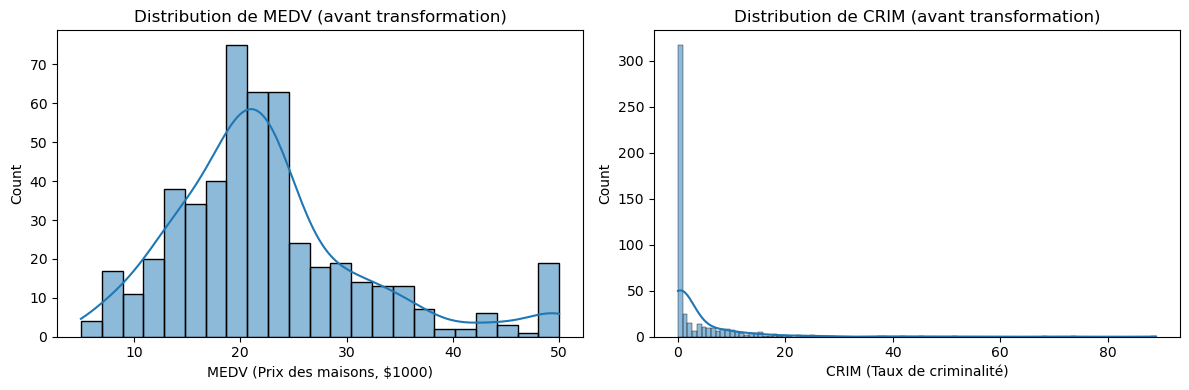

In [8]:
# Visualisation des distributions avant transformation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(data['MEDV'], kde=True)
plt.title('Distribution de MEDV (avant transformation)')
plt.xlabel('MEDV (Prix des maisons, $1000)')
plt.subplot(1, 2, 2)
sns.histplot(data['CRIM'], kde=True)
plt.title('Distribution de CRIM (avant transformation)')
plt.xlabel('CRIM (Taux de criminalité)')
plt.tight_layout()
plt.show()

### Étape 4 : Application des transformations logarithmiques

In [9]:
#Étape 4 : Application des transformations logarithmiques
# Transformation de la variable cible (MEDV) et de CRIM pour réduire l’asymétrie
data['log_MEDV'] = np.log10(data['MEDV'])  # Log base 10 pour MEDV
data['log_CRIM'] = np.log1p(data['CRIM'])  # Log1p pour CRIM (gère les zéros)

In [10]:
# Vérifier que MEDV est positif pour éviter les erreurs avec log
if (data_imputed['MEDV'] <= 0).any():
    print("Attention : MEDV contient des valeurs nulles ou négatives !")
    data_imputed['MEDV'] = data_imputed['MEDV'].clip(lower=0.0001)  # Remplacer par une petite valeur positive

data_imputed['log_MEDV'] = np.log10(data_imputed['MEDV'])
data_imputed['log_CRIM'] = np.log1p(data_imputed['CRIM'])

### Vérification de l'asymétrie après transformation

In [11]:
# Vérification de l'asymétrie après transformation
print("\nAsymétrie après transformation :")
print(data[['log_MEDV', 'log_CRIM']].skew())


Asymétrie après transformation :
log_MEDV   -0.330321
log_CRIM    1.300827
dtype: float64


### Visualisation des distributions après transformation

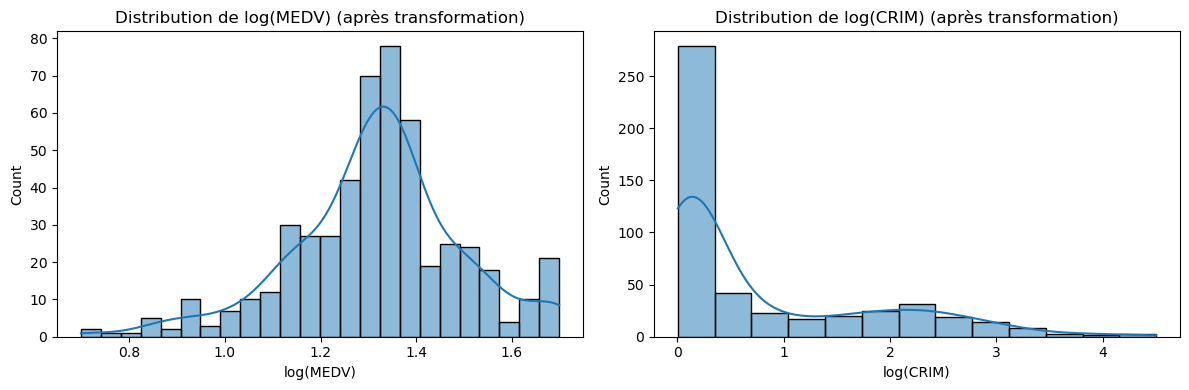

In [12]:
# Visualisation des distributions après transformation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(data['log_MEDV'], kde=True)
plt.title('Distribution de log(MEDV) (après transformation)')
plt.xlabel('log(MEDV)')
plt.subplot(1, 2, 2)
sns.histplot(data['log_CRIM'], kde=True)
plt.title('Distribution de log(CRIM) (après transformation)')
plt.xlabel('log(CRIM)')
plt.tight_layout()
plt.show()

### Étape 5 : Préparation des données pour la régression

In [13]:
# Étape 5 : Préparation des données pour la régression
# Variables explicatives (X) : toutes les colonnes sauf MEDV et log_MEDV
# Inclut log_CRIM au lieu de CRIM
X = data_imputed.drop(['MEDV', 'log_MEDV', 'CRIM'], axis=1)
y = data_imputed['log_MEDV']

### Étape 6 : Division en ensembles d'entraînement et de test

In [14]:
# Étape 6 : Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Étape 7 : Création et entraînement du modèle de régression linéaire

In [15]:
# Étape 7 : Création et entraînement du modèle de régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

### Étape 8 : Prédictions

In [16]:
# Étape 8 : Prédictions
y_pred = model.predict(X_test)

### Étape 9: Évaluation sur l'échelle logarithmique

In [17]:
# Étape 9: Évaluation sur l'échelle logarithmique
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
print("\nMétriques d'évaluation (sur log(MEDV)) :")
print(f"R² : {r2:.4f}")
print(f"MSE : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.4f}%")


Métriques d'évaluation (sur log(MEDV)) :
R² : 0.7195
MSE : 0.0082
RMSE : 0.0908
MAPE : 4.7676%


### Étape 10 : Évaluation sur l'échelle originale

In [18]:
# Étape 10: Évaluation sur l'échelle originale
y_test_original = 10 ** y_test
y_pred_original = 10 ** y_pred
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mape_original = mean_absolute_percentage_error(y_test_original, y_pred_original) * 100

print("\nMétriques d'évaluation (sur l'échelle originale) :")
print(f"RMSE : {rmse_original:.4f} $")
print(f"MAPE : {mape_original:.4f}%")


Métriques d'évaluation (sur l'échelle originale) :
RMSE : 4.3932 $
MAPE : 12.9846%


### Étape 11 : Interprétation des coefficients

In [19]:
# Étape 11 : Interprétation des coefficients
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print("\nCoefficients du modèle (sur log(MEDV)) :")
print(coefficients)


Coefficients du modèle (sur log(MEDV)) :
          Coefficient
ZN           0.000213
INDUS       -0.000060
CHAS         0.055723
NOX         -0.201353
RM           0.053761
AGE         -0.000187
DIS         -0.020420
RAD          0.005262
TAX         -0.000172
PTRATIO     -0.016330
B            0.000242
LSTAT       -0.011018
log_CRIM    -0.048546


<Figure size 1000x600 with 0 Axes>

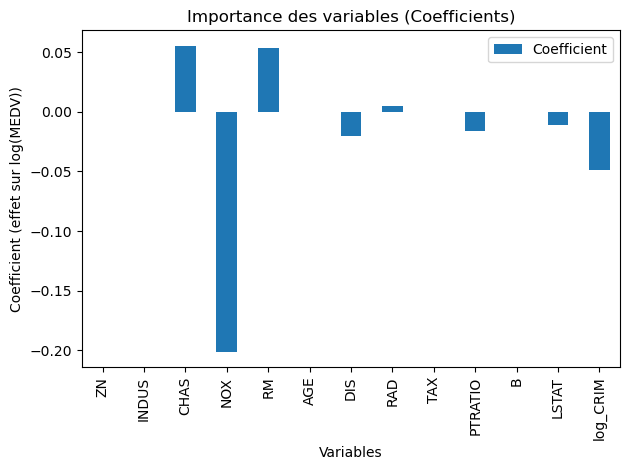

In [20]:
# Visualisation des coefficients
plt.figure(figsize=(10, 6))
coefficients.plot(kind='bar')
plt.title('Importance des variables (Coefficients)')
plt.xlabel('Variables')
plt.ylabel('Coefficient (effet sur log(MEDV))')
plt.tight_layout()
plt.show()

### Étape 12 : Analyse des résidus

In [21]:
# Étape 12 : Analyse des résidus
residuals = y_test - y_pred

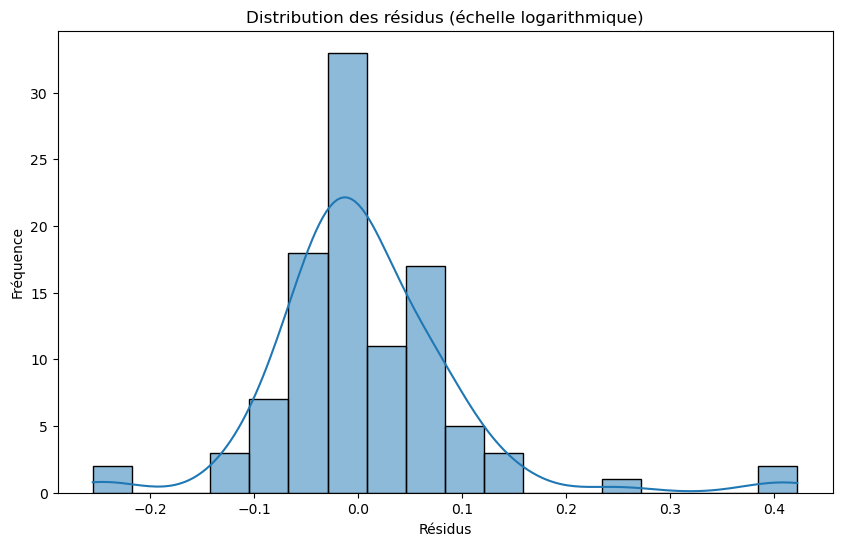

In [22]:
# Visualisation 1 : Histogramme des résidus
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution des résidus (échelle logarithmique)')
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.show()

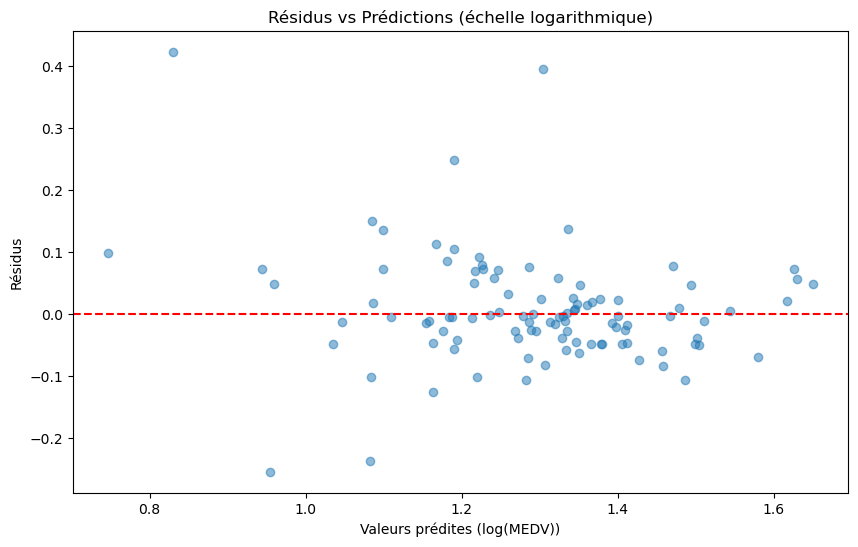

In [23]:
# Visualisation 2 : Résidus vs Prédictions
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Résidus vs Prédictions (échelle logarithmique)')
plt.xlabel('Valeurs prédites (log(MEDV))')
plt.ylabel('Résidus')
plt.show()

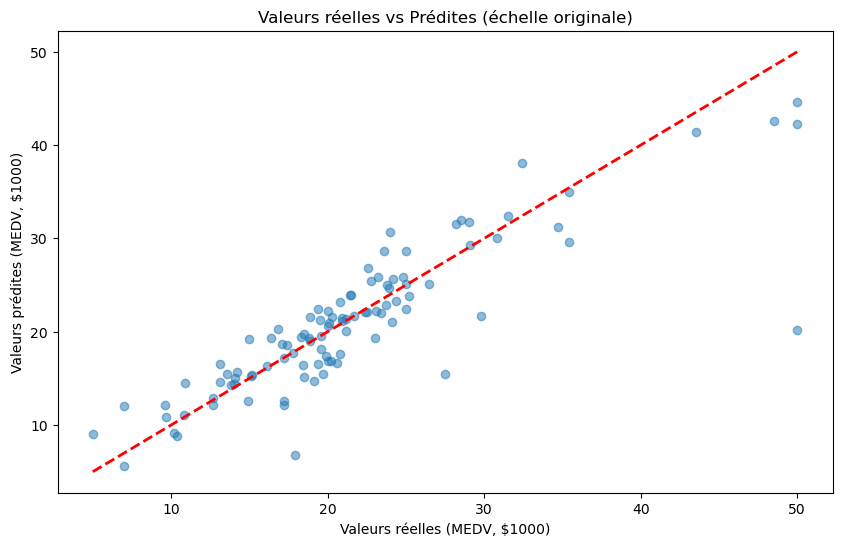

In [24]:
# Visualisation 3 : Valeurs réelles vs Prédites (échelle originale)
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original, alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
plt.title('Valeurs réelles vs Prédites (échelle originale)')
plt.xlabel('Valeurs réelles (MEDV, $1000)')
plt.ylabel('Valeurs prédites (MEDV, $1000)')
plt.show()

In [25]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("R² moyen (validation croisée) :", scores.mean())

R² moyen (validation croisée) : 0.5377598450611621


### Vérification des outliers

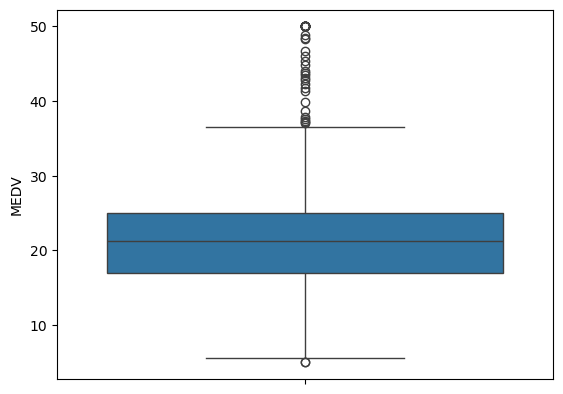

In [26]:
sns.boxplot(data_imputed['MEDV'])
plt.show()

### Testons une transformation logarithmique sur d’autres variables comme LSTAT ou DIS

In [27]:
data_imputed['log_LSTAT'] = np.log1p(data_imputed['LSTAT'])
X = data_imputed.drop(['MEDV', 'log_MEDV', 'CRIM', 'LSTAT'], axis=1)

### Ajoutez des interactions (par exemple, RM * LSTAT) avec PolynomialFeatures

In [28]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

### Standardisez X pour uniformiser les échelles et améliorer la convergence du modèle

In [29]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [31]:
#Évaluation après standardisation
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
print("\nMétriques d'évaluation après standardisation (sur log(MEDV)) :")
print(f"R² : {r2:.4f}")
print(f"MSE : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.4f}%")


Métriques d'évaluation après standardisation (sur log(MEDV)) :
R² : 0.7195
MSE : 0.0082
RMSE : 0.0908
MAPE : 4.7676%


### USage de Random Forest

In [32]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("R² Random Forest :", r2_score(y_test, y_pred_rf))

R² Random Forest : 0.8305809508367525


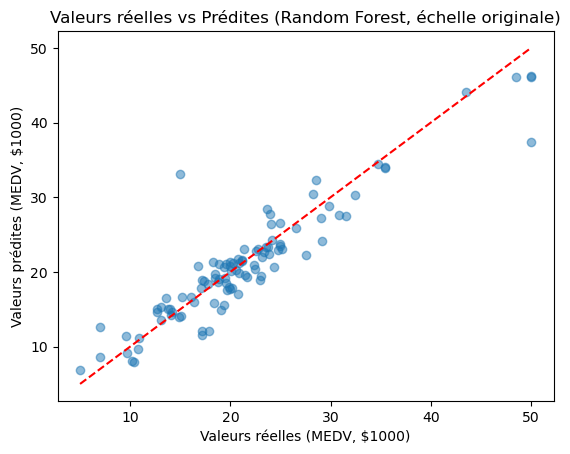

In [33]:
y_pred_rf_original = 10 ** y_pred_rf
plt.scatter(y_test_original, y_pred_rf_original, alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--')
plt.title('Valeurs réelles vs Prédites (Random Forest, échelle originale)')
plt.xlabel('Valeurs réelles (MEDV, $1000)')
plt.ylabel('Valeurs prédites (MEDV, $1000)')
plt.show()

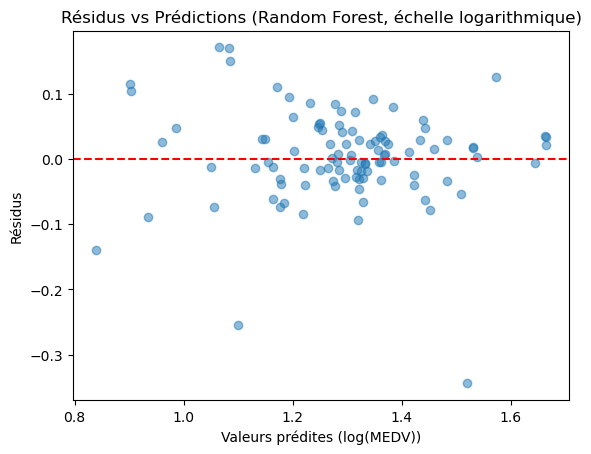

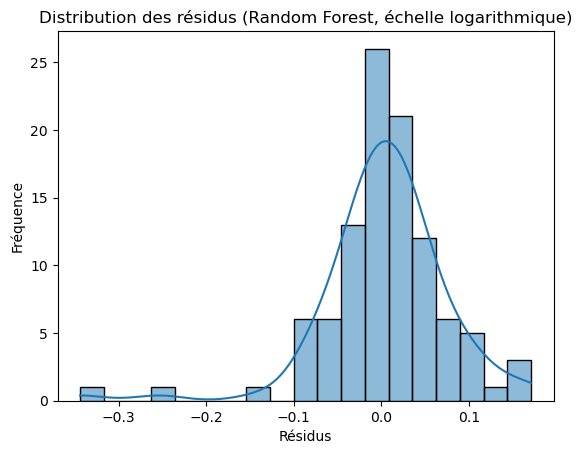

In [34]:
residuals_rf = y_test - y_pred_rf
plt.scatter(y_pred_rf, residuals_rf, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Résidus vs Prédictions (Random Forest, échelle logarithmique)')
plt.xlabel('Valeurs prédites (log(MEDV))')
plt.ylabel('Résidus')
plt.show()
sns.histplot(residuals_rf, kde=True)
plt.title('Distribution des résidus (Random Forest, échelle logarithmique)')
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.show()

In [35]:
rmse_rf = np.sqrt(mean_squared_error(y_test_original, 10 ** y_pred_rf))
mape_rf = mean_absolute_percentage_error(y_test_original, 10 ** y_pred_rf) * 100
print(f"RMSE Random Forest (échelle originale) : {rmse_rf:.4f} $")
print(f"MAPE Random Forest : {mape_rf:.4f}%")

RMSE Random Forest (échelle originale) : 3.2046 $
MAPE Random Forest : 11.4230%


In [36]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)
print("Meilleurs hyperparamètres :", grid_search.best_params_)
best_rf = grid_search.best_estimator_
print("R² avec meilleurs paramètres :", r2_score(y_test, best_rf.predict(X_test)))

Meilleurs hyperparamètres : {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
R² avec meilleurs paramètres : 0.8307716431470485


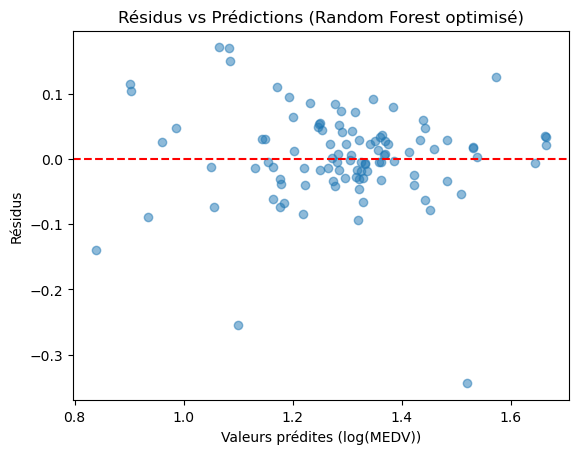

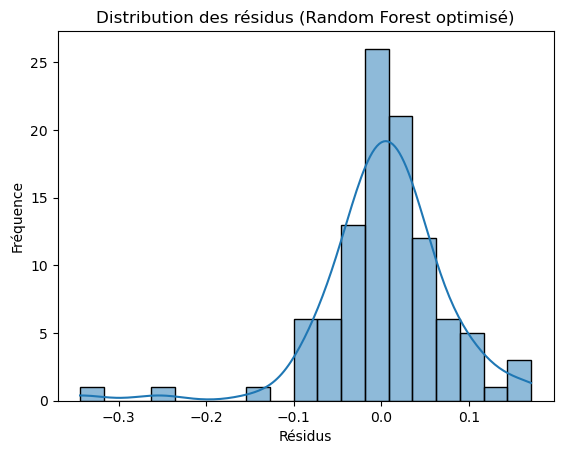

In [37]:
residuals_rf = y_test - y_pred_rf
plt.scatter(y_pred_rf, residuals_rf, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Résidus vs Prédictions (Random Forest optimisé)')
plt.xlabel('Valeurs prédites (log(MEDV))')
plt.ylabel('Résidus')
plt.show()
sns.histplot(residuals_rf, kde=True)
plt.title('Distribution des résidus (Random Forest optimisé)')
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.show()

In [38]:
importances = best_rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(feature_importance_df.sort_values(by='Importance', ascending=False))

      Feature  Importance
11   log_CRIM    0.495308
4          RM    0.247819
12  log_LSTAT    0.102597
6         DIS    0.050492
3         NOX    0.028791
10          B    0.018917
5         AGE    0.016141
8         TAX    0.015190
9     PTRATIO    0.012142
1       INDUS    0.006554
7         RAD    0.004480
0          ZN    0.000955
2        CHAS    0.000613


In [39]:
param_grid = {
    'n_estimators': [300, 400],
    'max_depth': [20, 25, 30],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)
print("Nouveaux meilleurs hyperparamètres :", grid_search.best_params_)

Nouveaux meilleurs hyperparamètres : {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 400}


In [40]:
X = data_imputed.drop(['MEDV', 'log_MEDV', 'CRIM', 'B'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_test)
print("R² sans B :", r2_score(y_test, y_pred_rf))
print("RMSE sans B :", np.sqrt(mean_squared_error(y_test_original, 10 ** y_pred_rf)))
print("MAPE sans B :", mean_absolute_percentage_error(y_test_original, 10 ** y_pred_rf) * 100)

R² sans B : 0.8284252279470274
RMSE sans B : 3.212436734516848
MAPE sans B : 11.42332604383379


In [41]:
param_grid = {
    'n_estimators': [400, 500],
    'max_depth': [20, 25, 30],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)
print("Nouveaux meilleurs hyperparamètres :", grid_search.best_params_)
best_rf = grid_search.best_estimator_
print("R² avec meilleurs paramètres :", r2_score(y_test, best_rf.predict(X_test)))

Nouveaux meilleurs hyperparamètres : {'max_depth': 25, 'min_samples_leaf': 1, 'n_estimators': 400}
R² avec meilleurs paramètres : 0.8277831917407628


In [42]:
data_imputed['log_DIS'] = np.log1p(data_imputed['DIS'])
X = data_imputed.drop(['MEDV', 'log_MEDV', 'CRIM'], axis=1)

In [75]:
scores_rf = cross_val_score(best_rf, X, y, cv=10, scoring='r2')
print("R² moyen Random Forest (10 plis) :", scores_rf.mean())

R² moyen Random Forest (10 plis) : 0.4923796374344742


In [77]:
from sklearn.model_selection import cross_val_predict
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Prédictions par validation croisée
y_pred_cv = cross_val_predict(best_rf, X, y, cv=10)

# Vraies valeurs en échelle originale (assurez-vous que data_imputed['MEDV'] est défini)
y_original = data_imputed['MEDV'].values  # Ou une autre source si transformée

# Calcul des métriques sur l'échelle originale
rmse_cv = np.sqrt(mean_squared_error(y_original, 10 ** y_pred_cv))
mape_cv = mean_absolute_percentage_error(y_original, 10 ** y_pred_cv) * 100

print(f"RMSE CV (échelle originale) : {rmse_cv:.4f} $")
print(f"MAPE CV : {mape_cv:.4f}%")

RMSE CV (échelle originale) : 4.5781 $
MAPE CV : 15.5982%


In [78]:
param_grid = {
    'n_estimators': [400, 500],
    'max_depth': [10, 15, 20],
    'min_samples_leaf': [2, 4, 6]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=10, scoring='r2')
grid_search.fit(X, y)
print("Nouveaux meilleurs hyperparamètres :", grid_search.best_params_)
best_rf = grid_search.best_estimator_
scores_rf = cross_val_score(best_rf, X, y, cv=10, scoring='r2')
print("R² moyen (10 plis) :", scores_rf.mean())

Nouveaux meilleurs hyperparamètres : {'max_depth': 15, 'min_samples_leaf': 2, 'n_estimators': 400}
R² moyen (10 plis) : 0.4847803027328338


In [79]:
Q1 = data_imputed['MEDV'].quantile(0.25)
Q3 = data_imputed['MEDV'].quantile(0.75)
IQR = Q3 - Q1
data_cleaned = data_imputed[(data_imputed['MEDV'] >= Q1 - 1.5 * IQR) & (data_imputed['MEDV'] <= Q3 + 1.5 * IQR)]
X = data_cleaned.drop(['MEDV', 'log_MEDV', 'CRIM'], axis=1)
y = data_cleaned['log_MEDV']
best_rf.fit(X, y)  # Réentraînez 
print("R² moyen après filtrage des outliers :", scores_rf.mean())


R² moyen après filtrage des outliers : 0.4847803027328338


## Usage de XGboost model

In [43]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle XGBoost avec paramètres par défaut
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Prédictions
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# Métriques sur l'échelle logarithmique
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
print(f"R² Train (log scale) : {r2_train:.4f}")
print(f"R² Test (log scale) : {r2_test:.4f}")

# Reconversion en échelle originale et métriques
y_train_original = 10 ** y_train  # Si y_train est log_MEDV
y_test_original = 10 ** y_test   # Si y_test est log_MEDV
y_pred_test_original = 10 ** y_pred_test

rmse_test = np.sqrt(mean_squared_error(y_test_original, y_pred_test_original))
mape_test = mean_absolute_percentage_error(y_test_original, y_pred_test_original) * 100
print(f"RMSE Test (original scale) : {rmse_test:.4f} $")
print(f"MAPE Test : {mape_test:.4f}%")

R² Train (log scale) : 1.0000
R² Test (log scale) : 0.8498
RMSE Test (original scale) : 2.8884 $
MAPE Test : 11.4650%


In [44]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}
grid_search = GridSearchCV(XGBRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print("Meilleurs hyperparamètres :", grid_search.best_params_)
best_xgb = grid_search.best_estimator_

y_pred_test = best_xgb.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)
y_pred_test_original = 10 ** y_pred_test
rmse_test = np.sqrt(mean_squared_error(y_test_original, y_pred_test_original))
mape_test = mean_absolute_percentage_error(y_test_original, y_pred_test_original) * 100
print(f"R² Test optimisé (log scale) : {r2_test:.4f}")
print(f"RMSE Test optimisé (original scale) : {rmse_test:.4f} $")
print(f"MAPE Test optimisé : {mape_test:.4f}%")

Meilleurs hyperparamètres : {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
R² Test optimisé (log scale) : 0.8663
RMSE Test optimisé (original scale) : 2.7277 $
MAPE Test optimisé : 10.1970%


In [45]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size=0.2, random_state=43)
best_xgb.fit(X_train_new, y_train_new)
y_pred_test_new = best_xgb.predict(X_test_new)
r2_test_new = r2_score(y_test_new, y_pred_test_new)
y_pred_test_new_original = 10 ** y_pred_test_new
rmse_test_new = np.sqrt(mean_squared_error(10 ** y_test_new, y_pred_test_new_original))
mape_test_new = mean_absolute_percentage_error(10 ** y_test_new, y_pred_test_new_original) * 100
print(f"R² Test (random_state=43) : {r2_test_new:.4f}")
print(f"RMSE Test (random_state=43) : {rmse_test_new:.4f} $")
print(f"MAPE Test (random_state=43) : {mape_test_new:.4f}%")

R² Test (random_state=43) : 0.8909
RMSE Test (random_state=43) : 3.1825 $
MAPE Test (random_state=43) : 10.4302%


In [46]:
y_pred_train = best_xgb.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)
print(f"R² Train optimisé (log scale) : {r2_train:.4f}")

R² Train optimisé (log scale) : 0.9701


In [47]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size=0.2, random_state=44)
best_xgb.fit(X_train_new, y_train_new)
y_pred_test_new = best_xgb.predict(X_test_new)
r2_test_new = r2_score(y_test_new, y_pred_test_new)
y_pred_test_new_original = 10 ** y_pred_test_new
rmse_test_new = np.sqrt(mean_squared_error(10 ** y_test_new, y_pred_test_new_original))
mape_test_new = mean_absolute_percentage_error(10 ** y_test_new, y_pred_test_new_original) * 100
print(f"R² Test (random_state=44) : {r2_test_new:.4f}")
print(f"RMSE Test (random_state=44) : {rmse_test_new:.4f} $")
print(f"MAPE Test (random_state=44) : {mape_test_new:.4f}%")

R² Test (random_state=44) : 0.8588
RMSE Test (random_state=44) : 2.8972 $
MAPE Test (random_state=44) : 11.5720%


In [49]:
param_grid = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [200, 300],
    'min_child_weight': [1, 2]
}
grid_search = GridSearchCV(XGBRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)
print("Nouveaux meilleurs hyperparamètres :", grid_search.best_params_)
best_xgb = grid_search.best_estimator_
# Répétez l’évaluation
y_pred_test = best_xgb.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)
y_pred_test_original = 10 ** y_pred_test
rmse_test = np.sqrt(mean_squared_error(y_test_original, y_pred_test_original))
mape_test = mean_absolute_percentage_error(y_test_original, y_pred_test_original) * 100
print(f"R² Test optimisé (log scale) : {r2_test:.4f}")
print(f"RMSE Test optimisé (original scale) : {rmse_test:.4f} $")
print(f"MAPE Test optimisé : {mape_test:.4f}%")

Nouveaux meilleurs hyperparamètres : {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
R² Test optimisé (log scale) : 0.8663
RMSE Test optimisé (original scale) : 2.7277 $
MAPE Test optimisé : 10.1970%


In [50]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size=0.2, random_state=45)
best_xgb.fit(X_train_new, y_train_new)
y_pred_test_new = best_xgb.predict(X_test_new)
r2_test_new = r2_score(y_test_new, y_pred_test_new)
y_pred_test_new_original = 10 ** y_pred_test_new
rmse_test_new = np.sqrt(mean_squared_error(10 ** y_test_new, y_pred_test_new_original))
mape_test_new = mean_absolute_percentage_error(10 ** y_test_new, y_pred_test_new_original) * 100
print(f"R² Test (random_state=45) : {r2_test_new:.4f}")
print(f"RMSE Test (random_state=45) : {rmse_test_new:.4f} $")
print(f"MAPE Test (random_state=45) : {mape_test_new:.4f}%")

R² Test (random_state=45) : 0.8688
RMSE Test (random_state=45) : 3.2631 $
MAPE Test (random_state=45) : 11.6797%


In [51]:
y_pred_train = best_xgb.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)
print(f"R² Train optimisé (log scale) : {r2_train:.4f}")

R² Train optimisé (log scale) : 0.9664


In [52]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size=0.2, random_state=46)
best_xgb.fit(X_train_new, y_train_new)
y_pred_test_new = best_xgb.predict(X_test_new)
r2_test_new = r2_score(y_test_new, y_pred_test_new)
y_pred_test_new_original = 10 ** y_pred_test_new
rmse_test_new = np.sqrt(mean_squared_error(10 ** y_test_new, y_pred_test_new_original))
mape_test_new = mean_absolute_percentage_error(10 ** y_test_new, y_pred_test_new_original) * 100
print(f"R² Test (random_state=46) : {r2_test_new:.4f}")
print(f"RMSE Test (random_state=46) : {rmse_test_new:.4f} $")
print(f"MAPE Test (random_state=46) : {mape_test_new:.4f}%")

R² Test (random_state=46) : 0.8108
RMSE Test (random_state=46) : 2.7875 $
MAPE Test (random_state=46) : 11.6712%


In [53]:
param_grid = {
    'max_depth': [2, 3],
    'learning_rate': [0.1, 0.2],
    'min_child_weight': [2, 3],
    'n_estimators': [200, 300]
}
grid_search = GridSearchCV(XGBRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)
print("Nouveaux meilleurs hyperparamètres :", grid_search.best_params_)
best_xgb = grid_search.best_estimator_
# Répétez l’évaluation
y_pred_test = best_xgb.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)
y_pred_test_original = 10 ** y_pred_test
rmse_test = np.sqrt(mean_squared_error(y_test_original, y_pred_test_original))
mape_test = mean_absolute_percentage_error(y_test_original, y_pred_test_original) * 100
print(f"R² Test optimisé (log scale) : {r2_test:.4f}")
print(f"RMSE Test optimisé (original scale) : {rmse_test:.4f} $")
print(f"MAPE Test optimisé : {mape_test:.4f}%")

Nouveaux meilleurs hyperparamètres : {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200}
R² Test optimisé (log scale) : 0.8700
RMSE Test optimisé (original scale) : 2.6252 $
MAPE Test optimisé : 10.2339%


In [54]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size=0.2, random_state=47)
best_xgb.fit(X_train_new, y_train_new)
y_pred_test_new = best_xgb.predict(X_test_new)
r2_test_new = r2_score(y_test_new, y_pred_test_new)
y_pred_test_new_original = 10 ** y_pred_test_new
rmse_test_new = np.sqrt(mean_squared_error(10 ** y_test_new, y_pred_test_new_original))
mape_test_new = mean_absolute_percentage_error(10 ** y_test_new, y_pred_test_new_original) * 100
print(f"R² Test (random_state=47) : {r2_test_new:.4f}")
print(f"RMSE Test (random_state=47) : {rmse_test_new:.4f} $")
print(f"MAPE Test (random_state=47) : {mape_test_new:.4f}%")

R² Test (random_state=47) : 0.8759
RMSE Test (random_state=47) : 3.3009 $
MAPE Test (random_state=47) : 10.0350%


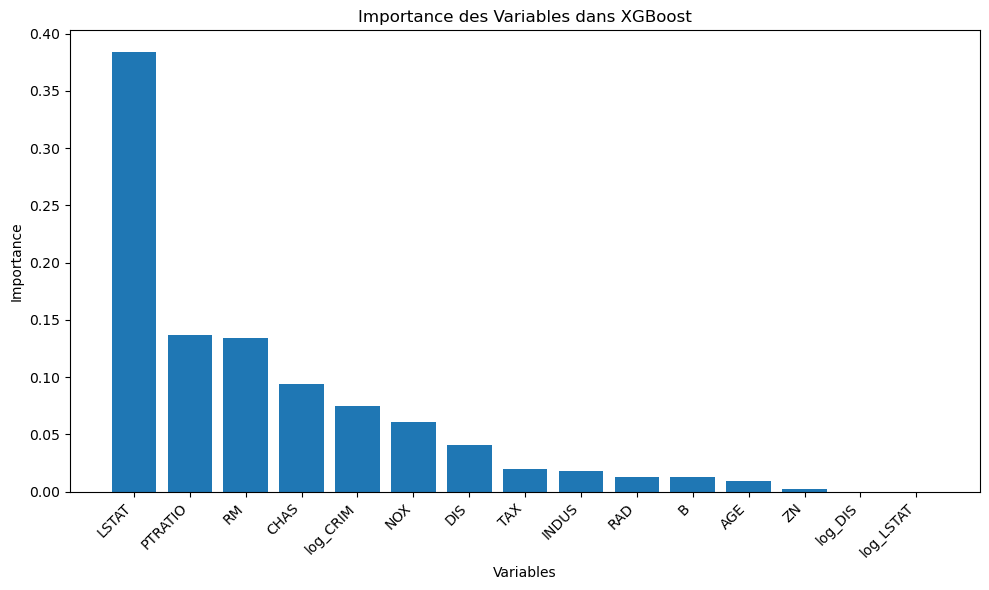

In [56]:
importances = best_xgb.feature_importances_
feature_names = X.columns  # Assurez-vous que X a des noms de colonnes

# Trier les importances par ordre décroissant
indices = np.argsort(importances)[::-1]
importances = importances[indices]
feature_names = feature_names[indices]

# Créer le bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances, align='center')
plt.xticks(range(X.shape[1]), feature_names, rotation=45, ha='right')
plt.xlabel('Variables')
plt.ylabel('Importance')
plt.title('Importance des Variables dans XGBoost')
plt.tight_layout()

# Afficher le graphique
plt.show()

In [58]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size=0.2, random_state=49)
best_xgb.fit(X_train_new, y_train_new)
y_pred_test_new = best_xgb.predict(X_test_new)
r2_test_new = r2_score(y_test_new, y_pred_test_new)
y_pred_test_new_original = 10 ** y_pred_test_new
rmse_test_new = np.sqrt(mean_squared_error(10 ** y_test_new, y_pred_test_new_original))
mape_test_new = mean_absolute_percentage_error(10 ** y_test_new, y_pred_test_new_original) * 100
print(f"R² Test (random_state=49) : {r2_test_new:.4f}")
print(f"RMSE Test (random_state=49) : {rmse_test_new:.4f} $")
print(f"MAPE Test (random_state=49) : {mape_test_new:.4f}%")

R² Test (random_state=49) : 0.8825
RMSE Test (random_state=49) : 3.3566 $
MAPE Test (random_state=49) : 10.5771%


In [59]:
y_pred_train = best_xgb.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)
print(f"R² Train optimisé (log scale) : {r2_train:.4f}")


R² Train optimisé (log scale) : 0.9701


In [60]:
import joblib
joblib.dump(best_xgb, 'xgboost_model.pkl')
print("Modèle sauvegardé avec succès !")

Modèle sauvegardé avec succès !


## Test du modèle

In [62]:
# Exemple de données d'entrée 
new_data = {
    'LSTAT': 10.0,    # Lower status of the population (%)
    'PTRATIO': 20.0,   # Pupil-teacher ratio
    'RM': 6.0,        # Average number of rooms
    'CHAS': 0,        # Charles River dummy variable (0 or 1)
    'NOX': 0.5,       # Nitric oxides concentration
    'DIS': 3.0,       # Weighted distances to employment centres
    'TAX': 300.0,     # Property-tax rate
    'INDUS': 10.0,    # Proportion of non-retail business acres
    'RAD': 5.0,       # Index of accessibility to radial highways
    'AGE': 50.0,      # Proportion of owner-occupied units built prior to 1940
    'ZN': 0.0,        # Proportion of residential land zoned for large lots
    'log_DIS': np.log1p(3.0),  # Log transform of DIS (exemple)
    'log_LSTAT': np.log1p(10.0)  # Log transform of LSTAT (exemple)
}

# Convertir en DataFrame
input_df = pd.DataFrame([new_data], columns=X.columns)

# Prédire (remplacez best_xgb par votre modèle entraîné)
prediction_log = best_xgb.predict(input_df)
prediction_original = 10 ** prediction_log[0]
print(f"Prédiction du prix médian (en $1000) : {prediction_original:.2f} $")

Prédiction du prix médian (en $1000) : 15.11 $


## Déploiement sur le PC

In [63]:
def predict_price(model, input_data):
    # Convertir les données en DataFrame
    input_df = pd.DataFrame([input_data], columns=['LSTAT', 'PTRATIO', 'RM', 'CHAS', 'NOX', 'DIS', 'TAX', 'INDUS', 'RAD', 'AGE', 'ZN', 'log_DIS', 'log_LSTAT'])
    # Prédire (ajustez les colonnes selon X.columns)
    prediction_log = model.predict(input_df)
    prediction_original = 10 ** prediction_log[0]  # Reconversion en échelle originale
    return prediction_original

In [68]:
# Données d'entrée avec toutes les colonnes attendues
new_data = {
    'LSTAT': 10.0,
    'PTRATIO': 20.0,
    'RM': 6.0,
    'CHAS': 0,
    'NOX': 0.5,
    'DIS': 3.0,
    'TAX': 300.0,
    'INDUS': 10.0,
    'RAD': 5.0,
    'AGE': 50.0,
    'ZN': 0.0,
    'log_DIS': np.log1p(3.0),
    'log_LSTAT': np.log1p(10.0),
    'B': 0.0,  # Valeur par défaut (à ajuster selon les données)
    'log_CRIM': np.log1p(0.1)  # Valeur par défaut (ajustez avec une moyenne si possible)
}

# Convertir en DataFrame avec les bonnes colonnes
input_df = pd.DataFrame([new_data], columns=['ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'log_CRIM', 'log_LSTAT', 'log_DIS'])

# Prédire
prediction_log = best_xgb.predict(input_df)
prediction_original = 10 ** prediction_log[0]
print(f"Prédiction du prix médian (en $1000) : {prediction_original:.2f} $")

Prédiction du prix médian (en $1000) : 17.36 $


In [69]:
from flask import Flask, request, jsonify
import joblib

app = Flask(__name__)
model = joblib.load('xgboost_model.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    prediction = predict_price(model, data)
    return jsonify({'predicted_price': prediction})

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

In [71]:
from flask import Flask, request, jsonify
import joblib
import pandas as pd
import numpy as np

app = Flask(__name__)
model = joblib.load('xgboost_model.pkl')  # Charger le modèle sauvegardé

def predict_price(model, input_data):
    input_df = pd.DataFrame([input_data], columns=['ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'log_CRIM', 'log_LSTAT', 'log_DIS'])
    prediction_log = model.predict(input_df)
    prediction_original = 10 ** prediction_log[0]
    return prediction_original

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    if not data:
        return jsonify({'error': 'Aucune donnée fournie'}), 400
    try:
        prediction = predict_price(model, data)
        return jsonify({'predicted_price': prediction})
    except Exception as e:
        return jsonify({'error': str(e)}), 500

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

In [ ]:
from flask import Flask, request, jsonify
import joblib
import pandas as pd
import numpy as np
import os  
app = Flask(__name__) 

try:
    model = joblib.load('xgboost_model.pkl')
    print("Modèle chargé avec succès !")
except Exception as e:
    print(f"Erreur lors du chargement du modèle : {e}")
    raise

def predict_price(model, input_data):
    expected_columns = ['ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'log_CRIM', 'log_LSTAT', 'log_DIS']
    input_df = pd.DataFrame([input_data])
    for col in expected_columns:
        if col not in input_df.columns:
            input_df[col] = 0.0
    input_df = input_df[expected_columns]
    try:
        prediction_log = model.predict(input_df)
        return 10 ** prediction_log[0]
    except Exception as e:
        raise ValueError(f"Erreur de prédiction : {e}")

@app.route('/predict', methods=['POST'])
def predict():
    try:
        data = request.get_json()
        if not data:
            return jsonify({'error': 'Aucune donnée fournie'}), 400
        prediction = predict_price(model, data)
        return jsonify({'Montant predit selon le modele': prediction})
    except Exception as e:
        return jsonify({'error': str(e)}), 500

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=int(os.environ.get('PORT', 5000)))  # Compatible avec Heroku


Modèle chargé avec succès !
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.1.147:5000
Press CTRL+C to quit
127.0.0.1 - - [17/Jun/2025 13:05:17] "POST /predict HTTP/1.1" 200 -
